# Notebook for preparing data features for analysis

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import librosa
from IPython.display import Audio
import mir_eval.sonify
from pydub import AudioSegment
from matplotlib.transforms import ScaledTranslation


from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport rp2

In [3]:
def Part_maps(Entries):
    parts_on = {}
    cols = Entries.columns
    for c in cols:
        if Entries[c].isna().sum()>1:
            Entries.loc[Entries[c].notna(),['mm',c]]
            V = Entries.loc[Entries[c].notna(),['mm',c]]
            parts_on[c]=V.rename(columns = {c:'Playing'})
            D = pd.DataFrame(index = parts_on[c].index )
            for i in D.index:
                if parts_on[c].loc[i,'Playing'] == 1.0:
                    D[i] = D.index-i
            D[D>=0] = np.nan
            D['Pre'] = D.max(axis=1)
            D.loc[parts_on[c].loc[:,'Playing'] == 1.0,'Pre'] = 0.0
            parts_on[c]['Pre'] = D['Pre']
            parts_on[c]['Post'] = parts_on[c]['Pre'].diff()
            parts_on[c].loc[parts_on[c]['Post']<=0,'Post'] = 0.0
            parts_on[c][parts_on[c].isna()] = 0.0
    return parts_on
def resp_shade(ax,breaths,cat,colour):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Period_T'], facecolor=colour,alpha = 0.2)
    return

def resp_shaded(ax,breaths,cat,colour,alph = 0.4):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Insp_T'], facecolor=colour,alpha = alph )
        ax.axvspan(r['Ex'],r['Ex']+r['Exp_T'], facecolor=colour,alpha = alph - 0.2)
    return

def quickcarresp(Breaths):
    Insp_seq = Breaths.copy()#.query('In > @xlim[0] and In < @xlim[1]').copy().reset_index(drop=True)
    Insp_seq.loc[:,'dPT'] = np.log(Insp_seq['Period_T']/Insp_seq['Period_T'].shift(1)).abs()
    Insp_seq.loc[:,'dIT'] = np.log(Insp_seq['Insp_T']/Insp_seq['Insp_T'].shift(1)).abs()
    Insp_seq.loc[:,'dID'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].shift(1)).abs()
    Insp_seq.loc[:,'relD'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].rolling(5,center=True).median()).abs()
    
    depth_thresh = Insp_seq['IDepth'].median()*2
    low_D =  Insp_seq['IDepth'].quantile(0.25)
    mD =  Insp_seq['IDepth'].median()
    mT =  Insp_seq['Period_T'].median() 
    mIT =  Insp_seq['Insp_T'].median()
    
    Insp_seq['Categories']='Disturbed'

    V =  Insp_seq.query('Insp_T>0.5 and Period_T>2 and IDepth<3*@low_D and IE_Ratio>0.2 and dPT<0.5 and dID<0.5')
    Insp_seq.loc[V.index,'Categories']='Quiet'
    
    return Insp_seq

In [4]:
data_out_loc = './outfiles/'

# Audio features

In [13]:
audio_loc = '/Users/finn/Desktop/Current_Projects/Stavanger/Data2024/Audio/Piece_wise/'

aud_file = audio_loc +'C5_Saev_10.mp3'
y, sr = librosa.load(aud_file)
rms =librosa.feature.rms(y=y, frame_length=256, hop_length=64, center=True, pad_mode='constant')
times = librosa.times_like(rms,sr = sr, hop_length=64)
rms_sf = int(sr/64)
aud_df = pd.DataFrame(index = times-1 ) 
aud_df['rms'] = rms[0]

buff = 10
C = librosa.cqt(y=y, sr=sr)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
times = (-buff+np.arange(len(C_db[0]))*(times[-1])/len(C_db[0])).round(3)
pitchticks = np.arange(7,84,12)
pitchticklabels=['C1','C2','C3','C4','C5','C6','C7']
C_df = pd.DataFrame(data=C_db).transpose()
C_df = C_df[C_df.columns[::-1]]
C_df.set_index(times,inplace = True)

In [12]:
# 249.413 # 252.080
times[-1]

270.08

In [14]:
C_df.to_csv(data_out_loc + 'C5_Saev_10_cqt.csv')

In [14]:
audio_loc = '/Users/finn/Desktop/Current_Projects/KORK/Data/Audio/Pieces/'
buff = 10
aud_file = audio_loc +'C1_Sae1_10.mp3' #C1_Sae1_1.mp3
y, sr = librosa.load(aud_file)
rms =librosa.feature.rms(y=y, frame_length=256, hop_length=64, center=True, pad_mode='constant')
times = librosa.times_like(rms,sr = sr, hop_length=64)
rms_sf = int(sr/64)
aud_df = pd.DataFrame(index = times-buff ) # + M_times.loc[segtag,'Start']
aud_df['rms'] = rms[0]

C = librosa.cqt(y=y, sr=sr)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
times = (-buff+np.arange(len(C_db[0]))*(times[-1])/len(C_db[0])).round(3) #2*buff+
pitchticks = np.arange(7,84,12)
pitchticklabels=['C1','C2','C3','C4','C5','C6','C7']
C_df = pd.DataFrame(data=C_db).transpose()
C_df = C_df[C_df.columns[::-1]]
C_df.set_index(times,inplace = True)

In [15]:
times[-1]

470.427

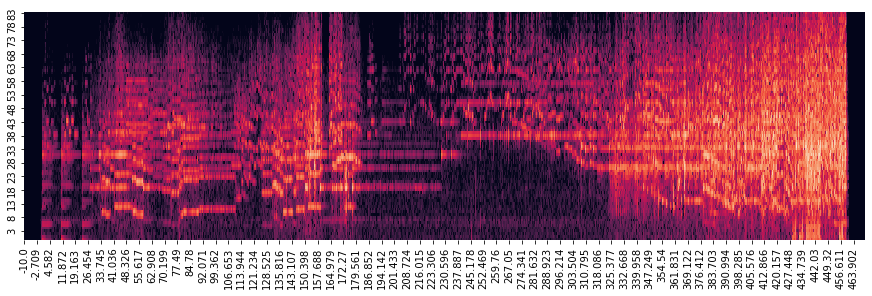

In [16]:
fig3 = plt.figure(constrained_layout=True,figsize=(12,4))
gs = fig3.add_gridspec(1, 3)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
chart = sns.heatmap(data=C_df.transpose(),cmap="rocket",ax=axes[0],cbar = False)

plt.show()

In [18]:
C_df.to_csv(data_out_loc + 'KORK_Sae1_10_cqt.csv')

# Gathering Physiology measurements

In [6]:
# audio file locations in
phys_loc = '../SSO/Signals/'
audio_loc = '/Users/finn/Desktop/Current_Projects/Stavanger/Data2024/Audio/Piece_wise/'
timing_loc = '/Users/finn/Desktop/Current_Projects/Stavanger/Data2024/Timing/'
baseDir = '/Users/finn/Desktop/Current_Projects/Stavanger/Data2024/'
# audio file locations out
Piece_timings = pd.read_csv(timing_loc + '/Lydo2024_Concerts_events.csv')
PartDets = pd.read_csv('/Users/finn/Desktop/Current_Projects/Stavanger/Data2024/Participants/Participant_Metadata.csv',index_col = 0)
player_order = list(PartDets.index)
Dets=PartDets.loc[player_order,['Section', 'Instrument','Part']].copy()
mydpi = 196

In [10]:
df_files = pd.DataFrame(columns=['PartID','NID','Performance','Segment','Signal','Measure','FileLoc'])
k = 0
for path, subdirs, files in os.walk('../SSO/Signals/Saev/'):
    for f in files:
#         print(f)
        fileloc = os.path.join(path, f)
        dets = f.split('_')
        measure = dets[-1]
        c = dets[0]
        if measure.endswith('.csv'):
            measure = measure[:-4]
            signal = measure[-3:]
            if signal == 'ATA': signal = 'DATA'
            if signal == 'ESP': signal = 'RESP'

            if dets[2].startswith('AU'): #if len(dets)==4: # from dress rehearsal or concert # C1_AST2_AU826_MSECG.csv
                df_files.loc[k,:] = {'PartID':dets[2],'NID':int(dets[2][2:5]),'Performance':dets[0],'Segment':dets[1],'Signal':signal,'Measure':measure,'FileLoc':fileloc}
                k+=1

print(len(df_files))
PhysFiles = df_files.copy()
df_files.loc[:5,:]

79


,PartID,NID,Performance,Segment,Signal,Measure,FileLoc
0,AU802,802,C5,Saev,DATA,EQDATA,../SSO/Signals/Saev/EQDATA/C5_Saev_AU802_EQDAT...
1,AU816,816,C7,Saev,DATA,EQDATA,../SSO/Signals/Saev/EQDATA/C7_Saev_AU816_EQDAT...
2,AU807,807,C5,Saev,DATA,EQDATA,../SSO/Signals/Saev/EQDATA/C5_Saev_AU807_EQDAT...
3,AU813,813,C7,Saev,DATA,EQDATA,../SSO/Signals/Saev/EQDATA/C7_Saev_AU813_EQDAT...
4,AU811,811,C5,Saev,DATA,EQDATA,../SSO/Signals/Saev/EQDATA/C5_Saev_AU811_EQDAT...
5,AU819,819,C7,Saev,DATA,EQDATA,../SSO/Signals/Saev/EQDATA/C7_Saev_AU819_EQDAT...


In [8]:
P5 = Piece_timings.loc[:,['Event', 'Related', 'Event_Type']]
P5['c_sTime'] = Piece_timings['C5']
P5['Performance'] = 'C5'
P5=P5.loc[P5['c_sTime'].notna(),:].copy()
P5['Duration_s'] = P5['c_sTime'].diff().shift(-1)
P7= Piece_timings.loc[:,['Event', 'Related', 'Event_Type']]
P7['Performance'] = 'C7'
P7['c_sTime'] = Piece_timings['C7']
P7=P7.loc[P7['c_sTime'].notna(),:].copy()
P7['Duration_s'] = P7['c_sTime'].diff().shift(-1)
Event_timings = pd.concat([P5,P7],axis=0).reset_index(drop=True)
Event_timings.query('Event_Type=="Music"')

,Event,Related,Event_Type,c_sTime,Performance,Duration_s
0,Marsj,Trad,Music,48.032000,C5,17.928000
4,20thCFox,Newm,Music,139.304000,C5,22.829333
7,Morgenstemning,Gri1,Music,193.880000,C5,92.920000
9,Ildfuglen,Stra,Music,298.120000,C5,97.216000
12,LaTraviata,Verd,Music,510.720000,C5,216.832000
15,Kjempervisesåtten,Saev,Music,829.440000,C5,250.080000
18,Hedvig,Will,Music,1167.133333,C5,130.741334
23,Elevbidrag,LieV,Music,1381.856000,C5,240.436000
25,BellaCiao,Izab,Music,1645.728000,C5,267.913333
28,NorskDans,Gri2,Music,1960.616000,C5,27.608000


In [13]:
ev = Event_timings.loc[15,:] # C5 Saev
ev

Event          Kjempervisesåtten
Related                     Saev
Event_Type                 Music
c_sTime                   829.44
Performance                   C5
Duration_s                250.08
Name: 15, dtype: object

In [11]:
segID = 'Saev'
partID = 'AU801'
subfiles = df_files.query('Segment==@segID and PartID==@partID')#.sort_values('NID').reset_index(drop = True)
# Event == @concert and 
subfiles.iloc[:15,:]

,PartID,NID,Performance,Segment,Signal,Measure,FileLoc
18,AU801,801,C5,Saev,DATA,EQDATA,../SSO/Signals/Saev/EQDATA/C5_Saev_AU801_EQDAT...
34,AU801,801,C5,Saev,IBI,EQCIBI,../SSO/Signals/Saev/EQCIBI/C5_Saev_AU801_EQCIB...
52,AU801,801,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU801_EQRES...
69,AU801,801,C5,Saev,ACC,EQBACC,../SSO/Signals/Saev/EQBACC/C5_Saev_AU801_EQBAC...


In [15]:
buff = 15
sf = 25
# for ind,ev in Event_timings.query('Type=="Activity"').loc[23:,:].iterrows():

piece = ev["Related"]
concert = ev['Performance']
dur = ev['Duration_s']
pstime0 = ev['c_sTime']
s_time = -buff #C_times.loc[0,concert]
e_time = dur+buff
time_s = s_time +  np.round(np.linspace(0,dur+2*buff,int(sf*(dur+2*buff)),endpoint=False),3)

dfs= PhysFiles.query('Segment==@piece and Performance==@concert')
# players = ['AU801', 'AU803', 'AU805', 'AU807', 'AU808', 'AU810'] # C5
player ='AU801' #'AU814'#'AU801'
df_feats = pd.DataFrame(index = time_s)
sig_list = []
sig = 'RESP'
A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
if len(A)>0:
    V = pd.read_csv(A['FileLoc'].values[0])
    sig_t = V['p_sTime']
    sig_v = V['Breathing']
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    df_feats.loc[:,'Resp_wave'] = f(time_s)
    sig_list.append(['Resp_wave'])
    R = V.set_index(sig_t,drop = True)
    Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(R['Breathing']),R['Breathing'])

sig = 'ACC'
A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
if len(A)>0:
    V = pd.read_csv(A['FileLoc'].values[0])
    sig_t = V['p_sTime']
    for tag in [ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']:
        f = interpolate.interp1d(sig_t,V.loc[:,tag],fill_value='extrapolate')
        df_feats.loc[:,'ACC'+tag.split(' ')[0]] = f(time_s)
    sig_v = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
    f = interpolate.interp1d(sig_t,sig_v.rolling(int(256/sf),center=True).mean(),fill_value='extrapolate')
    df_feats.loc[:,'Jerk'] = f(time_s)
    sig_list.append(['Jerk']) # ,'ACCVert','ACCLat','ACCLong'

df_feats.iloc[:5,:]

,Resp_wave,ACCVert,ACCLat,ACCLong,Jerk
-15.00,510.000000,-850.0,-576.00,220.0,NaN
-14.96,510.000000,-840.5,-560.00,238.0,10.809450
-14.92,510.179487,-836.0,-563.75,242.0,10.192913
-14.88,511.000000,-846.0,-566.00,246.0,9.402521
-14.84,511.225000,-851.0,-569.00,245.0,10.901633


In [ ]:
df_feats.to_csv('./data/Physiological_data/Case1_Saev_Feats.csv') 

Alternative respiration sequences to the same work from the audience

In [20]:
segID = 'Saev'
partID = 'AU801'
subfiles = df_files.query('Segment==@segID and PartID!=@partID and Signal =="RESP" and Performance=="C5"')#.sort_values('NID').reset_index(drop = True)
# Event == @concert and
other_partID = list(subfiles['PartID'])
subfiles.iloc[:15,:]

,PartID,NID,Performance,Segment,Signal,Measure,FileLoc
41,AU811,811,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU811_EQRES...
43,AU808,808,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU808_EQRES...
44,AU802,802,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU802_EQRES...
46,AU807,807,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU807_EQRES...
48,AU804,804,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU804_EQRES...
49,AU809,809,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU809_EQRES...
51,AU810,810,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU810_EQRES...
54,AU806,806,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU806_EQRES...
56,AU803,803,C5,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C5_Saev_AU803_EQRES...


In [21]:
df_feats = pd.DataFrame(index = time_s,columns = other_partID)
sig = 'RESP'
for player in other_partID:
    A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
    if len(A)>0:
        V = pd.read_csv(A['FileLoc'].values[0])
        sig_t = V['p_sTime']
        sig_v = V['Breathing']
        f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
        df_feats.loc[:,player] = f(time_s)
df_feats.iloc[:5,:]

,AU811,AU808,AU802,AU807,AU804,AU809,AU810,AU806,AU803
-15.00,493.0,342.153846,599.461538,510.358974,474.0,558.461538,501.461538,491.179487,502.0
-14.96,493.0,345.230769,601.512821,509.333333,474.0,549.230769,503.512821,492.205128,502.0
-14.92,493.0,348.307692,602.153846,509.0,474.846154,540.225,505.564103,493.0,502.0
-14.88,493.0,351.384615,598.461538,509.0,475.871795,534.0,507.615385,493.0,502.0
-14.84,492.641026,354.45,592.666667,509.0,476.0,526.871795,509.666667,493.25641,502.0


In [24]:
subfiles = df_files.query('Segment==@segID and PartID!=@partID and Signal =="RESP" and Performance=="C7"')#.sort_values('NID').reset_index(drop = True)
# Event == @concert and
other_partID = list(subfiles['PartID'])
subfiles.iloc[:15,:]

,PartID,NID,Performance,Segment,Signal,Measure,FileLoc
40,AU819,819,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU819_EQRES...
42,AU814,814,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU814_EQRES...
45,AU816,816,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU816_EQRES...
47,AU813,813,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU813_EQRES...
50,AU818,818,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU818_EQRES...
53,AU815,815,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU815_EQRES...
55,AU812,812,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU812_EQRES...
57,AU817,817,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU817_EQRES...
58,AU820,820,C7,Saev,RESP,EQRESP,../SSO/Signals/Saev/EQRESP/C7_Saev_AU820_EQRES...


In [25]:
for player in other_partID:
    A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
    if len(A)>0:
        V = pd.read_csv(A['FileLoc'].values[0])
        sig_t = V['p_sTime']
        sig_v = V['Breathing']
        f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
        df_feats.loc[:,player] = f(time_s)
df_feats.iloc[:5,:]

,AU811,AU808,AU802,AU807,AU804,AU809,AU810,AU806,AU803,AU819,AU814,AU816,AU813,AU818,AU815,AU812,AU817,AU820
-15.00,493.0,342.153846,599.461538,510.358974,474.0,558.461538,501.461538,491.179487,502.0,482.051282,481.000000,500.000000,498.000000,509.923077,501.000000,534.410256,509.820513,477.461538
-14.96,493.0,345.230769,601.512821,509.333333,474.0,549.230769,503.512821,492.205128,502.0,484.102564,481.000000,500.000000,498.000000,511.974359,501.000000,542.615385,510.846154,478.487179
-14.92,493.0,348.307692,602.153846,509.0,474.846154,540.225,505.564103,493.0,502.0,486.075000,480.230769,500.000000,498.948718,514.000000,501.000000,550.820513,512.743590,479.000000
-14.88,493.0,351.384615,598.461538,509.0,475.871795,534.0,507.615385,493.0,502.0,487.153846,479.205128,500.000000,499.000000,516.538462,501.000000,558.897436,513.897436,480.076923
-14.84,492.641026,354.45,592.666667,509.0,476.0,526.871795,509.666667,493.25641,502.0,489.205128,478.179487,499.128205,500.000000,519.615385,501.666667,565.769231,514.923077,481.564103


In [26]:
df_feats.to_csv('./data/Physiological_data/Case1_Saev_OtherResp.csv')

## KORK 

In [48]:
# audio file locations in
baseDir = '/Users/finn/Desktop/Current_Projects/KORK/Data/'
phys_loc = '../KORK/Signals/'
audio_loc =  baseDir + 'Audio/Pieces/'
timing_loc = baseDir + 'Timing/'
c = 'C1'
F = pd.read_csv(timing_loc + 'KORK2024_events - '+c+'_events.csv')
F['Performance'] = c
Event_timings = F
Event_timings['Duration_s'] = Event_timings['c_sTime'].diff().shift(-1)
PartDets = pd.read_csv( baseDir + 'Participants/Participant_Metadata.csv',index_col = 0)
player_order = list(PartDets.index)
Dets=PartDets.loc[player_order,['Section', 'Instrument','Part']].copy()

In [53]:
len(files)

750

In [54]:
df_files = pd.DataFrame(columns=['PartID','NID','Performance','Segment','Signal','Measure','FileLoc'])
k = 0
for path, subdirs, files in os.walk('../KORK/Signals/Sae/'):
    for f in files:
#         print(f)
        fileloc = os.path.join(path, f)
        dets = f.split('_')
        measure = dets[-1]
        c = dets[0]
        if measure.endswith('.csv'):
            measure = measure[:-4]
            signal = measure[-3:]
            if signal == 'ATA': signal = 'DATA'
            if signal == 'ESP': signal = 'RESP'
            #if dets[2].startswith('AU'): #
            if len(dets)==4: # from dress rehearsal or concert # C1_AST2_AU826_MSECG.csv
                df_files.loc[k,:] = {'PartID':dets[2],'NID':int(dets[2][2:5]),'Performance':dets[0],'Segment':dets[1],'Signal':signal,'Measure':measure,'FileLoc':fileloc}
                k+=1

print(len(df_files))
PhysFiles = df_files.copy()
df_files.loc[:5,:]

750


,PartID,NID,Performance,Segment,Signal,Measure,FileLoc
0,VA305,305,C1,Sae2,ACC,EQBACC,../KORK/Signals/Sae/C1_Sae2_VA305_EQBACC.csv
1,BR610,610,C1,Sae1,DATA,EQDATA,../KORK/Signals/Sae/C1_Sae1_BR610_EQDATA.csv
2,BR603,603,C1,Sae2,ACC,EQBACC,../KORK/Signals/Sae/C1_Sae2_BR603_EQBACC.csv
3,BR608,608,C1,Sae2,RESP,EQRESP,../KORK/Signals/Sae/C1_Sae2_BR608_EQRESP.csv
4,AU822,822,C1,Sae1,ACC,AX3ACC,../KORK/Signals/Sae/C1_Sae1_AU822_AX3ACC.csv
5,LS401,401,C1,Sae1,IBI,EQCIBI,../KORK/Signals/Sae/C1_Sae1_LS401_EQCIBI.csv


In [55]:
df_files.PartID.unique()

array(['VA305', 'BR610', 'BR603', 'BR608', 'AU822', 'LS401', 'VN102',
       'PC706', 'LS406', 'AU814', 'LS403', 'LS404', 'VN205', 'AU807',
       'VN202', 'WW506', 'AU805', 'AU818', 'AU802', 'VN207', 'WW508',
       'BR605', 'AU824', 'BR609', 'VA303', 'BR611', 'AU801', 'AU806',
       'VN203', 'AU808', 'VN204', 'AU803', 'VN206', 'WW509', 'AU804',
       'VN201', 'LS407', 'VN104', 'AU812', 'LS402', 'LS405', 'WW507',
       'WW502', 'WW505', 'AU815', 'VN106', 'PC705', 'VN101', 'PC702',
       'PC707', 'VN103', 'AU810', 'BR607', 'BR602', 'VA301', 'VA304',
       'AU813', 'PC704', 'VN107', 'PC703', 'VN105', 'PC701', 'AU811',
       'WW501', 'AU826', 'WW503', 'WW504', 'AU809', 'VA302', 'AU820',
       'BR601', 'BR606', 'AU817', 'BR604', 'AU827', 'AU821', 'AU816',
       'AU819', 'AU828', 'AU823', 'AU825'], dtype=object)

In [50]:
segID = 'Sae1'
partID = 'VN101'
subfiles = df_files.query('Segment==@segID and PartID==@partID')#.sort_values('NID').reset_index(drop = True)
# Event == @concert and 
subfiles.iloc[:15,:]

,PartID,NID,Performance,Segment,Signal,Measure,FileLoc


In [58]:
e_i = 19 # 75
ev = Event_timings.loc[e_i,:].copy()
piece = ev['Related']
if ev['Related'].startswith('Sae'):
    ev['Duration_s']  += Event_timings.loc[e_i+1,'Duration_s']
ev

buff = 15
sf = 25
dur = ev['Duration_s']
pstime0 = ev['c_sTime']
s_time = -buff #C_times.loc[0,concert]
e_time = dur+buff
time_s = s_time +  np.round(np.linspace(0,dur+2*buff,int(sf*(dur+2*buff)),endpoint=False),3)


c_sTime                            622.390567
Event                                   Saev1
Related                                  Sae1
Event_Type                              Music
Full_Title     Kjempeviseslåtten (1 Dirigent)
Composer                              Sævarud
Performer                                KORK
dTime                                     NaN
Tag               Sævarud - Kjempeviseslåtten
Performance                                C1
Duration_s                         460.451701
Name: 19, dtype: object

In [59]:
player ='AU815'#'VN101' #'AU815'#
buff = 15
sf = 25
print(ev)
dur = ev['Duration_s']
pstime0 = ev['c_sTime']
s_time = -buff #C_times.loc[0,concert]
e_time = dur+buff
time_s = s_time +  np.round(np.linspace(0,dur+2*buff,int(sf*(dur+2*buff)),endpoint=False),3)

dfs= PhysFiles.query('Segment==@piece')

df_feats = pd.DataFrame(index = time_s)
sig_list = []

sig = 'RESP'
A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
if len(A)>0:
    V = pd.read_csv(A['FileLoc'].values[0])
    sig_t = V['c_sTime']-pstime0
    sig_v = V['Breathing']
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    df_feats.loc[:,'Resp_wave'] = f(time_s)
    sig_list.append(['Resp_wave'])
    R = V.set_index(sig_t,drop = True)
    Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(R['Breathing']),R['Breathing'])
sig = 'ACC'
A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
if len(A)>0:
    V = pd.read_csv(A['FileLoc'].values[0])
    sig_t = V['c_sTime']-pstime0
    for tag in [ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']:
        f = interpolate.interp1d(sig_t,V.loc[:,tag],fill_value='extrapolate')
        df_feats.loc[:,'ACC'+tag.split(' ')[0]] = f(time_s)
    sig_v = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
    f = interpolate.interp1d(sig_t,sig_v.rolling(int(0.2*256),center=True).mean(),fill_value='extrapolate')
    df_feats.loc[:,'Jerk'] = f(time_s)
    sig_list.append(['Jerk'])

df_feats.iloc[:5,:]

c_sTime                            622.390567
Event                                   Saev1
Related                                  Sae1
Event_Type                              Music
Full_Title     Kjempeviseslåtten (1 Dirigent)
Composer                              Sævarud
Performer                                KORK
dTime                                     NaN
Tag               Sævarud - Kjempeviseslåtten
Performance                                C1
Duration_s                         460.451701
Name: 19, dtype: object


,Resp_wave,ACCVert,ACCLat,ACCLong,Jerk
-15.00,483.645305,-843.8331,-372.625175,251.833100,9.110727
-14.96,484.000000,-845.1669,-365.333800,254.624825,9.067648
-14.92,484.000000,-849.8331,-367.166900,256.707925,9.047475
-14.88,484.720381,-843.0669,-372.132925,254.000000,9.215380
-14.84,485.000000,-846.0000,-367.133800,261.000000,9.568623


In [60]:
df_feats.to_csv('./data/Physiological_data/Case2_Play1_Feats.csv') 

In [61]:
player ='VN101' #'AU815'#
buff = 15
sf = 25
dur = ev['Duration_s']
pstime0 = ev['c_sTime']
s_time = -buff #C_times.loc[0,concert]
e_time = dur+buff
time_s = s_time +  np.round(np.linspace(0,dur+2*buff,int(sf*(dur+2*buff)),endpoint=False),3)

dfs= PhysFiles.query('Segment==@piece')

df_feats = pd.DataFrame(index = time_s)
sig_list = []

sig = 'RESP'
A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
if len(A)>0:
    V = pd.read_csv(A['FileLoc'].values[0])
    sig_t = V['c_sTime']-pstime0
    sig_v = V['Breathing']
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    df_feats.loc[:,'Resp_wave'] = f(time_s)
    sig_list.append(['Resp_wave'])
    R = V.set_index(sig_t,drop = True)
    Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(R['Breathing']),R['Breathing'])
sig = 'ACC'
A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
if len(A)>0:
    V = pd.read_csv(A['FileLoc'].values[0])
    sig_t = V['c_sTime']-pstime0
    for tag in [ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']:
        f = interpolate.interp1d(sig_t,V.loc[:,tag],fill_value='extrapolate')
        df_feats.loc[:,'ACC'+tag.split(' ')[0]] = f(time_s)
    sig_v = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
    f = interpolate.interp1d(sig_t,sig_v.rolling(int(0.2*256),center=True).mean(),fill_value='extrapolate')
    df_feats.loc[:,'Jerk'] = f(time_s)
    sig_list.append(['Jerk'])

df_feats.iloc[:5,:]

,Resp_wave,ACCVert,ACCLat,ACCLong,Jerk
-15.00,520.0,-915.742075,-190.2993,162.2676,15.563875
-14.96,520.0,-931.700700,-113.0000,166.5669,17.491697
-14.92,520.0,-923.566900,-134.8345,199.0000,17.709795
-14.88,520.0,-991.992075,-150.2993,242.0000,15.223813
-14.84,520.0,-1034.257925,-197.2676,250.0000,15.754027


In [62]:
df_feats.to_csv('./data/Physiological_data/Conductor_Play1_Feats.csv') 

In [78]:
e_i = 75
ev = Event_timings.loc[e_i,:].copy()
piece = ev['Related']
if ev['Related'].startswith('Sae'):
    ev['Duration_s']  += Event_timings.loc[e_i+1,'Duration_s']
ev

c_sTime                                8097.253878
Event                                        Saev2
Related                                       Sae2
Event_Type                                   Music
Full_Title     Kjempeviseslåtten (2 Konsertmester)
Composer                           Harald Saevarud
Performer                                     KORK
dTime                                          NaN
Tag                    Sævarud - Kjempeviseslåtten
Performance                                     C1
Duration_s                              447.423673
Name: 75, dtype: object

In [79]:
player ='AU815'#
buff = 15
sf = 25
dur = ev['Duration_s']
pstime0 = ev['c_sTime']
s_time = -buff #C_times.loc[0,concert]
e_time = dur+buff
time_s = s_time +  np.round(np.linspace(0,dur+2*buff,int(sf*(dur+2*buff)),endpoint=False),3)

# time warping between first and second performance based on audio
dwt = pd.read_csv(baseDir + 'Audio/alignments/Sae/C1_Sae1_1-C1_Sae2.csv',index_col=0)
dwt.iloc[0,2]=dwt.iloc[0,2]-buff+1
dwt.iloc[-1,2]=dwt.iloc[-1,2]+buff+1
dwt.iloc[0,3]=dwt.iloc[0,3]-buff+1
dwt.iloc[-1,3]=dwt.iloc[-1,3]+buff+1
t_Alt = dwt.iloc[:,3].values-1
t_C1 =  dwt.iloc[:,2].values-1
f = interpolate.interp1d(t_Alt,t_C1,fill_value='extrapolate',kind='linear')
time_alt = f(time_s)

dfs= PhysFiles.query('Segment==@piece')

df_feats = pd.DataFrame(index = time_s)
df_feats['Time_1'] = time_alt
sig_list = []

sig = 'RESP'
A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
if len(A)>0:
    V = pd.read_csv(A['FileLoc'].values[0])
    sig_t = V['c_sTime']-pstime0
    sig_v = V['Breathing']
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    df_feats.loc[:,'Resp_wave'] = f(time_alt)

sig = 'ACC'
A = PhysFiles.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
if len(A)>0:
    V = pd.read_csv(A['FileLoc'].values[0])
    sig_t = V['c_sTime']-pstime0
    for tag in [ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']:
        f = interpolate.interp1d(sig_t,V.loc[:,tag],fill_value='extrapolate')
        df_feats.loc[:,'ACC'+tag.split(' ')[0]] = f(time_alt)
    sig_v = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
    f = interpolate.interp1d(sig_t,sig_v.rolling(int(0.2*256),center=True).mean(),fill_value='extrapolate')
    df_feats.loc[:,'Jerk'] = f(time_alt)
# df_files
df_feats.iloc[:5,:]

,Time_1,Resp_wave,ACCVert,ACCLat,ACCLong,Jerk
-15.00,-15.00,498.365846,-881.000000,-337.122000,152.244,11.596252
-14.96,-14.96,504.266410,-870.000000,-333.963500,147.366,10.687148
-14.92,-14.92,509.115692,-878.213500,-339.122000,140.488,11.514375
-14.88,-14.88,513.218256,-880.341500,-339.878000,148.000,11.535183
-14.84,-14.84,516.990615,-871.170667,-336.951333,148.000,11.143510


In [80]:
df_feats.to_csv('./data/Physiological_data/Case2_Play2_Feats.csv') 

## other audience members signals during Sae1

In [110]:
e_i = 75 #19 #75
ev = Event_timings.loc[e_i,:].copy()
piece = ev['Related']
if ev['Related'].startswith('Sae'):
    ev['Duration_s']  += Event_timings.loc[e_i+1,'Duration_s']

buff = 15
sf = 25
dur = ev['Duration_s']
pstime0 = ev['c_sTime']
s_time = -buff #C_times.loc[0,concert]
e_time = dur+buff
time_s = s_time +  np.round(np.linspace(0,dur+2*buff,int(sf*(dur+2*buff)),endpoint=False),3)


In [111]:
partIDs = df_files.query('Segment==@piece')['PartID'].unique()


In [112]:
df_feats = pd.DataFrame(index=time_s)
sig = 'RESP'
for player in partIDs:
    if player.startswith('AU'):
        A = df_files.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
        if len(A)>0:
            V = pd.read_csv(A['FileLoc'].values[0])
            sig_t = V['p_sTime']
            sig_v = V['Breathing']
            f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
            df_feats.loc[:,player] = f(time_s)
df_feats.iloc[:5,:]

,AU814,AU801,AU808,AU803,AU804,AU815,AU812,AU810,AU811,AU805,AU809,AU806,AU802,AU813,AU807
-15.00,492.727641,436.000000,496.0,466.000000,535.275795,498.365846,516.245550,500.000000,497.000000,607.003385,502.0,497.704564,525.429641,476.429077,494.607128
-14.96,493.000000,436.240462,496.0,465.924205,537.327077,504.266410,515.226205,500.000000,497.000000,598.824462,502.0,497.269795,528.961846,479.337333,495.000000
-14.92,493.778923,437.000000,496.0,463.872923,539.189179,509.115692,514.200564,500.953282,497.712256,591.543538,502.0,497.755846,532.298308,481.582923,495.000000
-14.88,494.000000,437.000000,496.0,461.821641,540.429641,513.218256,514.000000,501.000000,498.737897,582.329950,502.0,498.000000,536.958718,484.219949,495.658410
-14.84,494.000000,437.317385,496.0,459.655538,542.000000,516.990615,513.149282,501.000000,499.761586,573.312769,502.0,498.000000,542.086923,485.245590,495.315949


In [113]:
df_feats.to_csv('./data/Physiological_data/Case2_Sae2_AudResp.csv')

In [114]:
df_feats = pd.DataFrame(index=time_s)
sig = 'ACC'
for player in partIDs:
    if player.startswith('AU'):
        A = df_files.loc[(PhysFiles['PartID'] == player) & (PhysFiles['Signal'].str.endswith(sig)) & (PhysFiles['Segment'] == piece)]
        if len(A)>0:
            V = pd.read_csv(A['FileLoc'].values[0])
            sig_t = V['c_sTime']-pstime0
            sig_v = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
            f = interpolate.interp1d(sig_t,sig_v.rolling(int(0.2*256),center=True).mean(),fill_value='extrapolate')
            df_feats.loc[:,player] = f(time_s)
df_feats.iloc[:5,:]

,AU814,AU818,AU824,AU801,AU808,AU803,AU804,AU815,AU812,AU810,...,AU819,AU802,AU813,AU807,AU823,AU822,AU817,AU825,AU828,AU827
-15.00,11.521328,9.822246,12.250747,13.086901,10.871736,11.594890,10.874226,11.596252,11.615192,11.679853,...,11.404631,11.196112,11.522310,10.766818,14.387370,12.570293,11.461238,13.145642,17.772964,10.901613
-14.96,11.100420,9.095303,12.276044,11.806790,11.273077,11.364577,10.402528,10.687148,11.692741,11.464682,...,11.842215,11.502702,11.484871,11.414620,14.015144,12.084632,10.537565,11.953371,16.022086,11.419762
-14.92,11.633849,9.087971,14.154814,12.880386,11.179931,11.648216,9.740343,11.514375,12.109988,11.193543,...,12.734172,12.754435,11.240701,11.136938,12.585083,11.092092,10.061925,12.657652,14.681421,13.643096
-14.88,11.629719,9.825307,13.967177,12.969117,11.527001,11.668389,10.980762,11.535183,11.815679,11.006342,...,11.227001,13.360179,10.620524,10.454750,13.391347,11.691628,11.706815,11.590921,14.039552,14.548628
-14.84,10.927610,10.173603,12.933256,12.913909,11.515765,12.105736,11.298899,11.143510,11.934464,11.013564,...,11.248486,13.693624,9.850216,10.581960,12.104628,12.344529,13.000933,12.563236,13.421564,13.769822


In [115]:
df_feats.to_csv('./data/Physiological_data/Case2_Sae2_AudJerk.csv')